In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 96
import numpy as np
import pandas as pd
import seaborn as sns
import os

from scipy.ndimage import gaussian_filter1d
# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting
from chromoscores.snipping import tad_snippet_sectors

from chromoscores.snipping import *
from chromoscores.snipping import peak_snipping
from chromoscores.scorefunctions import peak_score
from chromoscores.snipping import tad_snippet_sectors
import warnings
warnings.filterwarnings('ignore')

In [2]:
def smooth(x, sigma = 1.5):
        return gaussian_filter1d(x, sigma)
def dots_motifs_overlap(dots, motif):
    dots = dots.rename({'chrom1': 'chrom', 'start1': 'start', 'end1': 'end'}, axis=1)
    dots_motifs = bioframe.overlap(dots, motif, how='inner')
    dots_motifs = dots_motifs.rename({'chrom':'chrom1', 'start':'start1', 'end':'end1', 'strand_':'strand1'}, axis=1)
    dots_motifs = dots_motifs.rename({'chrom2':'chrom', 'start2':'start','end2':'end'}, axis=1)
    dots_motifs_s = bioframe.overlap(dots_motifs, motif, how='inner')
    dots_motifs = dots_motifs_s.rename({'chrom':'chrom2', 'start':'start2','end':'end2', 'strand_':'strand2'}, axis=1)
    return dots_motifs[['chrom1','start1','end1','strand1', 'chrom2','start2', 'end2', 'strand2']]


### CTCF peaks from chip-seq

In [3]:
ctcf = bioframe.read_table('/project/fudenber_735/yxiao977/frip_sm_data/ChIP_fastqs_maps/Justice_2020_mm10/SRR10099910/SRR10099910.q30.mm10.sort_peaks.narrowPeak', schema='bed')
ctcf['mid']=(ctcf.end+ctcf.start)/2

In [4]:
ctcf['quartile_score']=pd.qcut(ctcf['score'],4, labels=False) + 1
ctcf_quart=ctcf[ctcf['quartile_score']==4]

### ctcf from JASPAR data

In [5]:
direct='/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz'
motif=bioframe.read_table(direct)
motif.head()
motif=motif.rename(columns={0: 'chrom', 1: 'start',2:'end',3:'name',4:'score',5:'pval',6:'strand'})
motif

chrom     start       end  name  score  pval strand
0       chr10   3103662   3103681  CTCF    814   410      -
1       chr10   3108121   3108140  CTCF    859   504      -
2       chr10   3119020   3119039  CTCF    801   386      -
3       chr10   3124081   3124100  CTCF    807   397      -
4       chr10   3127081   3127100  CTCF    810   403      +
...       ...       ...       ...   ...    ...   ...    ...
825505   chrY  90829177  90829196  CTCF    842   465      +
825506   chrY  90839573  90839592  CTCF    804   392      +
825507   chrY  90839785  90839804  CTCF    885   565      -
825508   chrY  90839787  90839806  CTCF    842   465      +
825509   chrY  90844314  90844333  CTCF    822   426      +

[825510 rows x 7 columns]

In [6]:
motif['quartile_score_motif']=pd.qcut(motif['score'],4,labels=False) + 1

### overlap

In [7]:
peaks_motifs = bioframe.overlap(ctcf,motif,how='inner')
peaks_motifs = peaks_motifs[(peaks_motifs['chrom']!= 'chrX')&(peaks_motifs['chrom']!= 'chrY')]
peaks_motifs=peaks_motifs.rename(columns={'strand':'strand_','strand_':'strand'})
peaks_motifs=peaks_motifs[['chrom','start','end','name','score','mid','quartile_score','strand']]


### binning the sites

In [8]:
peaks_motifs_cluster = bioframe.cluster(peaks_motifs, min_dist=10000)#
# Group by 'chuster_start' and 'cluster_end' and get the index of rows with the max 'score' within each group
idx = peaks_motifs_cluster.groupby(['cluster_start', 'cluster_end'])['score'].idxmax()

# Filter the dataframe to keep only the rows with the max 'score' in each group
peaks_motifs_bin_s = peaks_motifs_cluster.loc[idx].reset_index(drop=True)

### loading Hi-C data, Bonev 2017, Liu 2021 & Micro-C Hsieh 2021

In [9]:
# high-resolution reprocessed publically-available data from Bonev et al. 2017
res = 10_000
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
darzacq = '/project/fudenber_735/GEO/Hsieh_2020/Micro-C/Cool/GSE130275_mESC_WT_combined_1.3B.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/'+str(res))
darzacq_cooler = cooler.Cooler(darzacq+'::/1')
view_df_bonev = cooltools.lib.make_cooler_view(bonev_cooler)[:19]
view_df_darzacq = cooltools.lib.make_cooler_view(darzacq_cooler)

prefix_dir_liu = '/project/fudenber_735/GEO/liu_deWit_GSE181848/'
cooler_prefix_liu = prefix_dir_liu
sample_dict_liu ={
    'Wapl-0h':'GSM5512837_HiC.01_WAPL_0h.mcool',
    'Wapl-6h':'GSM5512838_HiC.02_WAPL_6h.mcool'
}
sample='Wapl-6h'
mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)
view_df_liu = view_df_liu[view_df_liu['chrom'].isin(view_df_bonev['chrom'])]

# data from Liu 2021
prefix_dir_liu_new = '/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/distiller-mm10/results/coolers_library/'
cooler_prefix_liu_new = prefix_dir_liu_new
sample_dict_liu_new ={
    'Wapl-0h_new':'liu_wapl0h.mm10.mapq_30.1000.mcool',
    'Wapl-24h_new':'liu_wapl24h.mm10.mapq_30.1000.mcool'
}
sample='Wapl-24h_new'
mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
liu_new_cooler = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
view_df_liu_new = cooltools.lib.make_cooler_view(liu_new_cooler)[:19]


### visualizing some dots

In [10]:
dots_from_peaks = peaks_motifs_bin_s
dots_from_peaks = dots_from_peaks.rename(columns={'chrom':'chrom1', 'start':'start1','end':'end1'})
dots_from_peaks['chrom2'] = dots_from_peaks['chrom1']
dots_from_peaks['start2'] = dots_from_peaks['start1']
dots_from_peaks['end2'] = dots_from_peaks['end1']

In [11]:
dots_from_peaks = peaks_motifs_bin_s[peaks_motifs_bin_s['chrom']=='chr1']
dots_from_peaks = dots_from_peaks.rename(columns={'chrom':'chrom1', 'start':'start1','end':'end1'})
dots_from_peaks['chrom2'] = dots_from_peaks['chrom1']
dots_from_peaks['start2'] = dots_from_peaks['start1']
dots_from_peaks['end2'] = dots_from_peaks['end1']
dots_from_peaks


chrom1     start1       end1                                 name   
261     chr1    4142587    4142853     SRR10099910.q30.mm10.sort_peak_1  \
279     chr1    4228248    4228459     SRR10099910.q30.mm10.sort_peak_2   
298     chr1    4297196    4297351     SRR10099910.q30.mm10.sort_peak_3   
308     chr1    4332532    4332829     SRR10099910.q30.mm10.sort_peak_4   
313     chr1    4346252    4346530     SRR10099910.q30.mm10.sort_peak_5   
...      ...        ...        ...                                  ...   
29981   chr1  194879563  194879893  SRR10099910.q30.mm10.sort_peak_3195   
29982   chr1  194962248  194962539  SRR10099910.q30.mm10.sort_peak_3198   
29983   chr1  194976166  194976743  SRR10099910.q30.mm10.sort_peak_3199   
29984   chr1  195040477  195040747  SRR10099910.q30.mm10.sort_peak_3200   
29985   chr1  195241408  195241856  SRR10099910.q30.mm10.sort_peak_3204   

       score          mid  quartile_score strand  cluster  cluster_start   
261      333    4142720.0               3      -        0        4142587  \
279      185    4228353.5               2      -        1        4228248   
298       55    4297273.5               1      -        2        4297196   
308      371    4332680.5               3      -        3        4332532   
313      312    4346391.0               3      -        4        4346252   
...      ...          ...             ...    ...      ...            ...   
29981    894  194879728.0               4      +     2082      194879563   
29982    478  194962393.5               3      -     2083      194952981   
29983    596  194976454.5               4      +     2084      194976166   
29984    553  195040612.0               3      +     2085      195040477   
29985    730  195241632.0               4      +     2086      195232686   

       cluster_end chrom2     start2       end2  
261        4142853   chr1    4142587    4142853  
279        4228459   chr1    4228248    4228459  
298        4297351   chr1    4297196    4297351  
308        4332829   chr1    4332532    4332829  
313        4346530   chr1    4346252    4346530  
...            ...    ...        ...        ...  
29981    194879893   chr1  194879563  194879893  
29982    194962539   chr1  194962248  194962539  
29983    194976743   chr1  194976166  194976743  
29984    195040747   chr1  195040477  195040747  
29985    195241856   chr1  195241408  195241856  

[2087 rows x 14 columns]

In [12]:
peaks_motifs_bin_s_quartile = peaks_motifs_bin_s[peaks_motifs_bin_s['quartile_score']>3]

In [13]:
dots_from_peaks = peaks_motifs_bin_s[peaks_motifs_bin_s['chrom']=='chr1']
dots_from_peaks = dots_from_peaks.rename(columns={'chrom':'chrom1', 'start':'start1','end':'end1'})
result = dots_from_peaks.merge(dots_from_peaks, how='cross', suffixes=('', '_2'))

# Rename columns for clarity
result = result.rename(columns={'chrom1_2': 'chrom2', 'start1_2': 'start2', 'end1_2': 'end2'})

<Figure size 1056x1056 with 0 Axes>

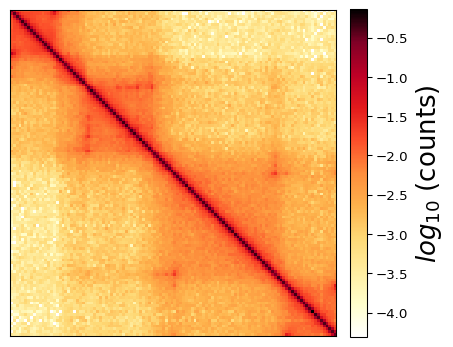

In [14]:
%matplotlib inline
plt.figure(figsize=(11,11))

region = 'chr1:153555000-155000000'
mat = cooler.Cooler(darzacq+'::/10').matrix(balance=True).fetch(region)
region_start = bioframe.parse_region_string(region)[1]
region_end = bioframe.parse_region_string(region)[2]
im = plt.matshow(np.log10(mat),cmap='fall')
cbar = plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(raw counts)')
cbar.set_label(r'$log_{10}$ (counts)', fontsize=19.5)
## plotting the dots ##
result_n = result.iloc[::1]
dots = result_n
region_dots = bioframe.select(dots, region, cols=['chrom1','start1','end1'])
#print(region_dots)

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

### peak score vs distance

In [15]:
# mustache dots from bonev2017
# to run mustache for calling peaks:
# mustache -f /project/fudenber_735/GEO/liu_deWit_GSE181848/GSM5512837_HiC.01_WAPL_0h.mcool -r 10kb -pt 0.1 -o cooler_WAPL_0h_pt_0.1_all.tsv

dot_dir = '/home1/rahmanin/start/polychrom/projects/Dynamic_boundary_elements/analysis/mustache_loops/'
prefix_dir_liu = '/project/fudenber_735/GEO/liu_deWit_GSE181848/'
cooler_prefix_liu = prefix_dir_liu
dots = pd.read_table(dot_dir+'cooler_WAPL_6h_pt_0.1_all_d10m.tsv')
dots_wapl = pd.read_table(dot_dir+'cooler_WAPL_0h_pt_0.1_all_d10m.tsv')
dots_05 = pd.read_table(dot_dir+'cooler_WAPL_0h_pt_0.05_all_d10m.tsv')
dots.rename(columns={'BIN1_CHR':'chrom1',
                     'BIN1_START':'start1','BIN1_END':'end1',
                     'BIN2_CHROMOSOME':'chrom2','BIN2_START':'start2','BIN2_END':'end2',
                    'DETECTION_SCALE':'strength'},inplace=True)
dots_wapl.rename(columns={'BIN1_CHR':'chrom1',
                     'BIN1_START':'start1','BIN1_END':'end1',
                     'BIN2_CHROMOSOME':'chrom2','BIN2_START':'start2','BIN2_END':'end2',
                    'DETECTION_SCALE':'strength'},inplace=True)
dots_05.rename(columns={'BIN1_CHR':'chrom1',
                     'BIN1_START':'start1','BIN1_END':'end1',
                     'BIN2_CHROMOSOME':'chrom2','BIN2_START':'start2','BIN2_END':'end2',
                    'DETECTION_SCALE':'strength'},inplace=True)

[100000.0, 110000.0, 119500.0, 125350.0, 132955.0, 142841.5, 155693.95, 172402.135, 194122.77550000005, 222359.60815000004, 259067.49059500004, 306787.7377735001, 368824.05910555006, 449471.2768372151, 554312.6598883797, 690606.4578548936, 867788.3952113617, 1098124.9137747702, 1397562.3879072014, 1786831.104279362, 2292880.4355631704, 2950744.566232122, 3805967.9361017584, 4917758.316932286, 6363085.812011973, 8242011.555615564, 10684615.022300234, 13859999.528990304, 17987999.387687396, 23354399.203993615, 30330718.965191703]
[100000.0, 110000.0, 119500.0, 125350.0, 132955.0, 142841.5, 155693.95, 172402.135, 194122.77550000005, 222359.60815000004, 259067.49059500004, 306787.7377735001, 368824.05910555006, 449471.2768372151, 554312.6598883797, 690606.4578548936, 867788.3952113617, 1098124.9137747702, 1397562.3879072014, 1786831.104279362, 2292880.4355631704, 2950744.566232122, 3805967.9361017584, 4917758.316932286, 6363085.812011973, 8242011.555615564, 10684615.022300234, 13859999.528

INFO:coolpuppy:('chr19', 'chr19'): 1274
INFO:coolpuppy:('chr18', 'chr18'): 1171
INFO:coolpuppy:('chr17', 'chr17'): 1201
INFO:coolpuppy:('chr14', 'chr14'): 1384
INFO:coolpuppy:('chr10', 'chr10'): 2368
INFO:coolpuppy:('chr15', 'chr15'): 1947
INFO:coolpuppy:('chr16', 'chr16'): 2128
INFO:coolpuppy:('chr12', 'chr12'): 2218
INFO:coolpuppy:('chr13', 'chr13'): 2377
INFO:coolpuppy:('chr3', 'chr3'): 2000
INFO:coolpuppy:('chr6', 'chr6'): 2279
INFO:coolpuppy:('chr4', 'chr4'): 2943
INFO:coolpuppy:('chr11', 'chr11'): 3348
INFO:coolpuppy:('chr1', 'chr1'): 2913
INFO:coolpuppy:('chr8', 'chr8'): 2266
INFO:coolpuppy:('chr9', 'chr9'): 2312
INFO:coolpuppy:('chr5', 'chr5'): 4068
INFO:coolpuppy:('chr7', 'chr7'): 3298
INFO:coolpuppy:('chr2', 'chr2'): 4709
INFO:coolpuppy:Total number of piled up windows: 46204


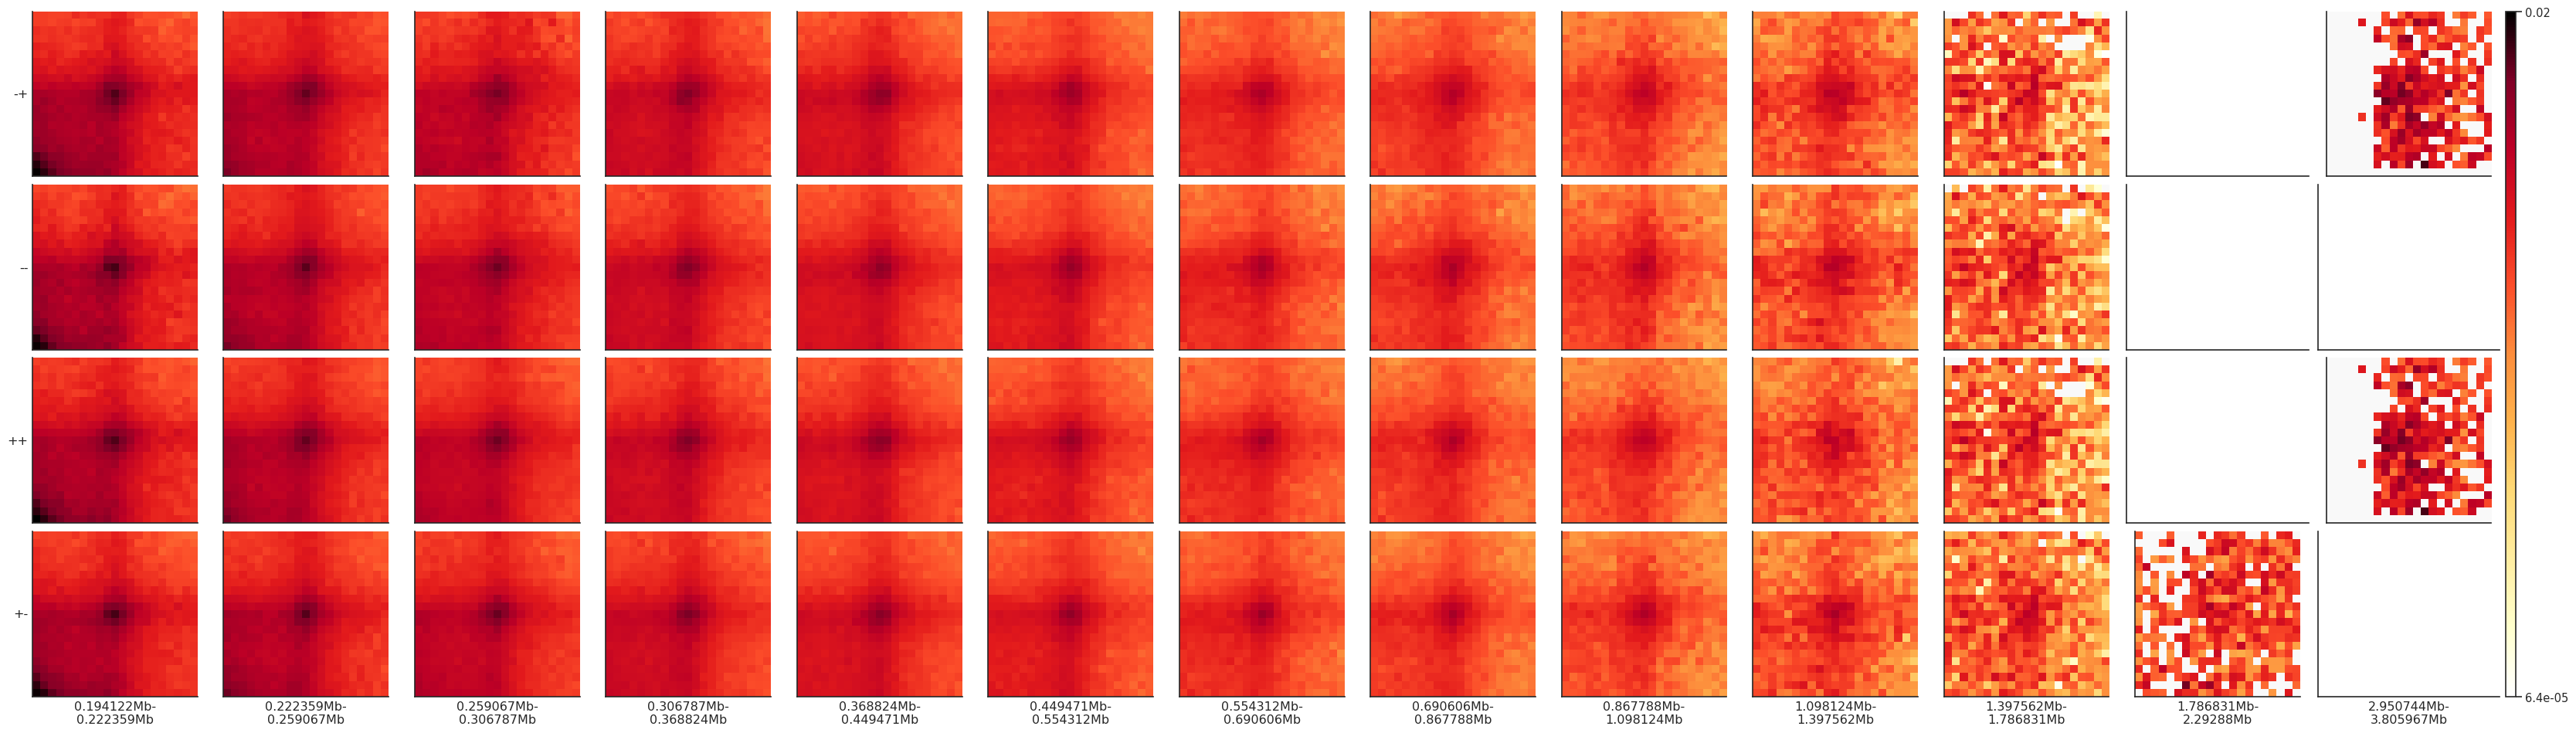

1.7938878814254207e-05


INFO:coolpuppy:('chr19', 'chr19'): 1274
INFO:coolpuppy:('chr18', 'chr18'): 1171
INFO:coolpuppy:('chr17', 'chr17'): 1201
INFO:coolpuppy:('chr14', 'chr14'): 1384
INFO:coolpuppy:('chr16', 'chr16'): 2128
INFO:coolpuppy:('chr15', 'chr15'): 1947
INFO:coolpuppy:('chr12', 'chr12'): 2218
INFO:coolpuppy:('chr13', 'chr13'): 2377
INFO:coolpuppy:('chr10', 'chr10'): 2368
INFO:coolpuppy:('chr3', 'chr3'): 2000
INFO:coolpuppy:('chr6', 'chr6'): 2279
INFO:coolpuppy:('chr11', 'chr11'): 3348
INFO:coolpuppy:('chr4', 'chr4'): 2943
INFO:coolpuppy:('chr1', 'chr1'): 2913
INFO:coolpuppy:('chr8', 'chr8'): 2266
INFO:coolpuppy:('chr9', 'chr9'): 2312
INFO:coolpuppy:('chr5', 'chr5'): 4068
INFO:coolpuppy:('chr2', 'chr2'): 4709
INFO:coolpuppy:('chr7', 'chr7'): 3298
INFO:coolpuppy:Total number of piled up windows: 46204


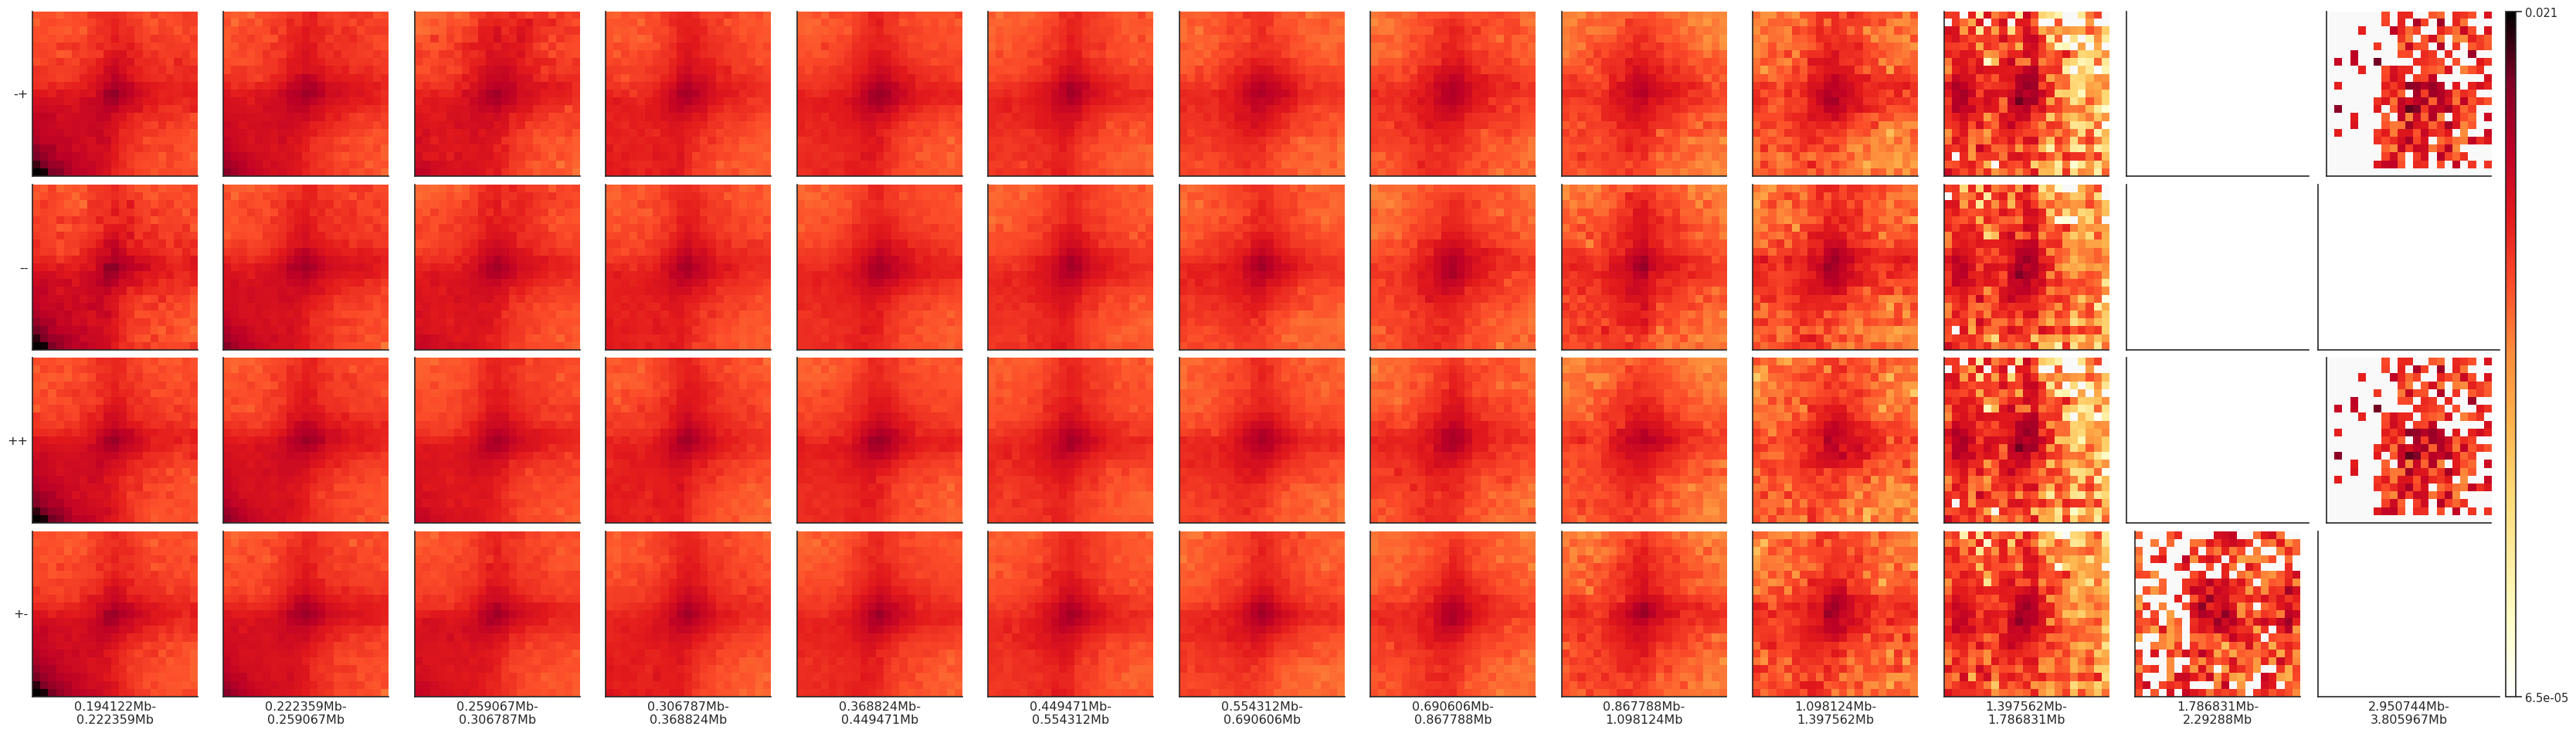

[100000.0, 110000.0, 119500.0, 125350.0, 132955.0, 142841.5, 155693.95, 172402.135, 194122.77550000005, 222359.60815000004, 259067.49059500004, 306787.7377735001, 368824.05910555006, 449471.2768372151, 554312.6598883797, 690606.4578548936, 867788.3952113617, 1098124.9137747702, 1397562.3879072014, 1786831.104279362, 2292880.4355631704, 2950744.566232122, 3805967.9361017584, 4917758.316932286, 6363085.812011973, 8242011.555615564, 10684615.022300234, 13859999.528990304, 17987999.387687396, 23354399.203993615, 30330718.965191703, 39399934.654749215, 51189915.05117398, 66516889.566526175, 86441956.43648404]
1.8363751141241197e-05


INFO:coolpuppy:('chr19', 'chr19'): 706
INFO:coolpuppy:('chr17', 'chr17'): 847
INFO:coolpuppy:('chr18', 'chr18'): 892
INFO:coolpuppy:('chr15', 'chr15'): 1519
INFO:coolpuppy:('chr13', 'chr13'): 1904
INFO:coolpuppy:('chr16', 'chr16'): 1617
INFO:coolpuppy:('chr14', 'chr14'): 1129
INFO:coolpuppy:('chr10', 'chr10'): 1714
INFO:coolpuppy:('chr12', 'chr12'): 1834
INFO:coolpuppy:('chr6', 'chr6'): 1720
INFO:coolpuppy:('chr3', 'chr3'): 1634
INFO:coolpuppy:('chr11', 'chr11'): 2221
INFO:coolpuppy:('chr4', 'chr4'): 2075
INFO:coolpuppy:('chr1', 'chr1'): 2371
INFO:coolpuppy:('chr5', 'chr5'): 2781
INFO:coolpuppy:('chr8', 'chr8'): 1397
INFO:coolpuppy:('chr7', 'chr7'): 2076
INFO:coolpuppy:('chr9', 'chr9'): 1774
INFO:coolpuppy:('chr2', 'chr2'): 2896
INFO:coolpuppy:Total number of piled up windows: 33107


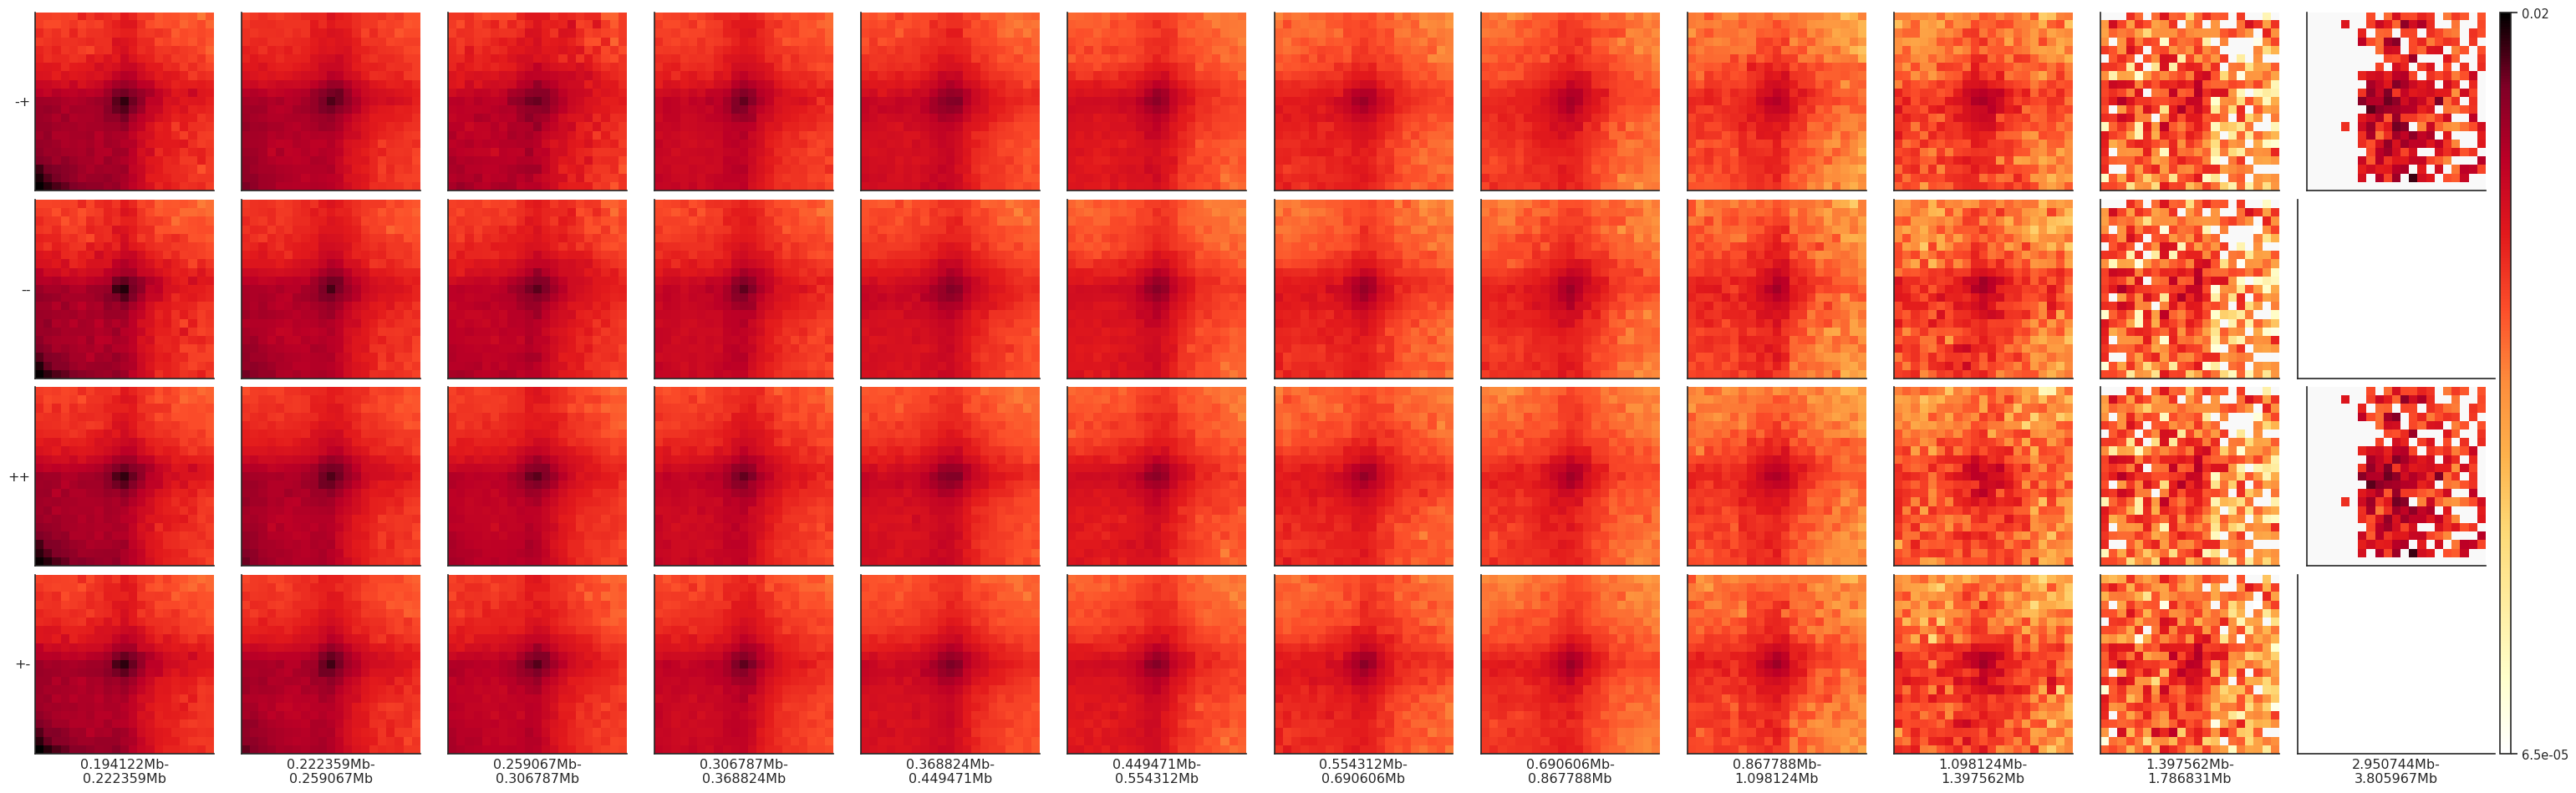

1.7938878814254207e-05


INFO:coolpuppy:('chr19', 'chr19'): 706
INFO:coolpuppy:('chr17', 'chr17'): 847
INFO:coolpuppy:('chr18', 'chr18'): 892
INFO:coolpuppy:('chr14', 'chr14'): 1129
INFO:coolpuppy:('chr16', 'chr16'): 1617
INFO:coolpuppy:('chr15', 'chr15'): 1519
INFO:coolpuppy:('chr12', 'chr12'): 1834
INFO:coolpuppy:('chr10', 'chr10'): 1714
INFO:coolpuppy:('chr13', 'chr13'): 1904
INFO:coolpuppy:('chr4', 'chr4'): 2075
INFO:coolpuppy:('chr6', 'chr6'): 1720
INFO:coolpuppy:('chr3', 'chr3'): 1634
INFO:coolpuppy:('chr11', 'chr11'): 2221
INFO:coolpuppy:('chr8', 'chr8'): 1397
INFO:coolpuppy:('chr1', 'chr1'): 2371
INFO:coolpuppy:('chr5', 'chr5'): 2781
INFO:coolpuppy:('chr7', 'chr7'): 2076
INFO:coolpuppy:('chr9', 'chr9'): 1774
INFO:coolpuppy:('chr2', 'chr2'): 2896
INFO:coolpuppy:Total number of piled up windows: 33107


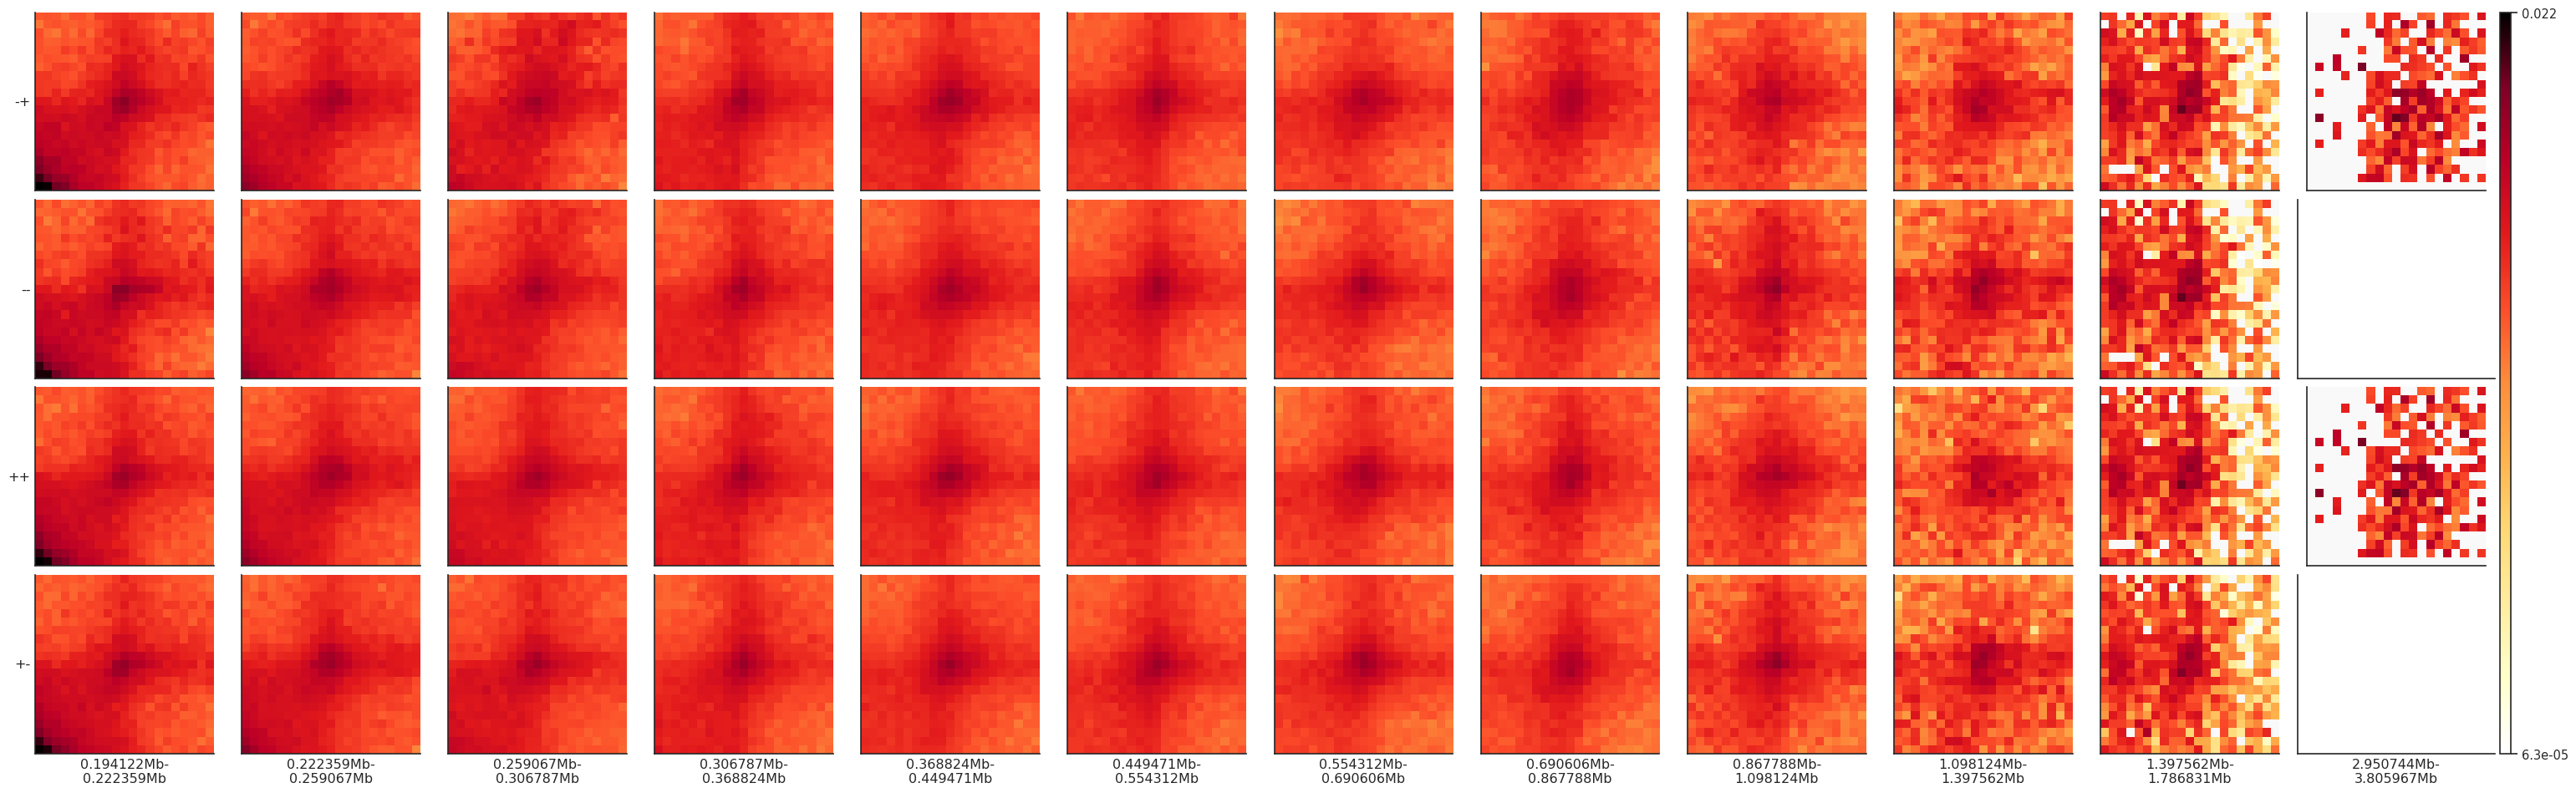

[100000.0, 110000.0, 119500.0, 125350.0, 132955.0, 142841.5, 155693.95, 172402.135, 194122.77550000005, 222359.60815000004, 259067.49059500004, 306787.7377735001, 368824.05910555006, 449471.2768372151, 554312.6598883797, 690606.4578548936, 867788.3952113617, 1098124.9137747702, 1397562.3879072014, 1786831.104279362, 2292880.4355631704, 2950744.566232122, 3805967.9361017584, 4917758.316932286, 6363085.812011973, 8242011.555615564, 10684615.022300234, 13859999.528990304, 17987999.387687396, 23354399.203993615, 30330718.965191703, 39399934.654749215, 51189915.05117398, 66516889.566526175, 86441956.43648404]
1.8363751141241197e-05


INFO:coolpuppy:('chr14', 'chr14'): 3613
INFO:coolpuppy:('chr18', 'chr18'): 3609
INFO:coolpuppy:('chr19', 'chr19'): 5183
INFO:coolpuppy:('chr13', 'chr13'): 5411
INFO:coolpuppy:('chr17', 'chr17'): 5710
INFO:coolpuppy:('chr3', 'chr3'): 4870
INFO:coolpuppy:('chr16', 'chr16'): 5932
INFO:coolpuppy:('chr6', 'chr6'): 7472
INFO:coolpuppy:('chr12', 'chr12'): 6808
INFO:coolpuppy:('chr15', 'chr15'): 7404
INFO:coolpuppy:('chr10', 'chr10'): 7617
INFO:coolpuppy:('chr4', 'chr4'): 7941
INFO:coolpuppy:('chr1', 'chr1'): 9281
INFO:coolpuppy:('chr11', 'chr11'): 14466
INFO:coolpuppy:('chr8', 'chr8'): 7803
INFO:coolpuppy:('chr9', 'chr9'): 8378
INFO:coolpuppy:('chr5', 'chr5'): 13060
INFO:coolpuppy:('chr2', 'chr2'): 13714
INFO:coolpuppy:('chr7', 'chr7'): 10480
INFO:coolpuppy:Total number of piled up windows: 148752


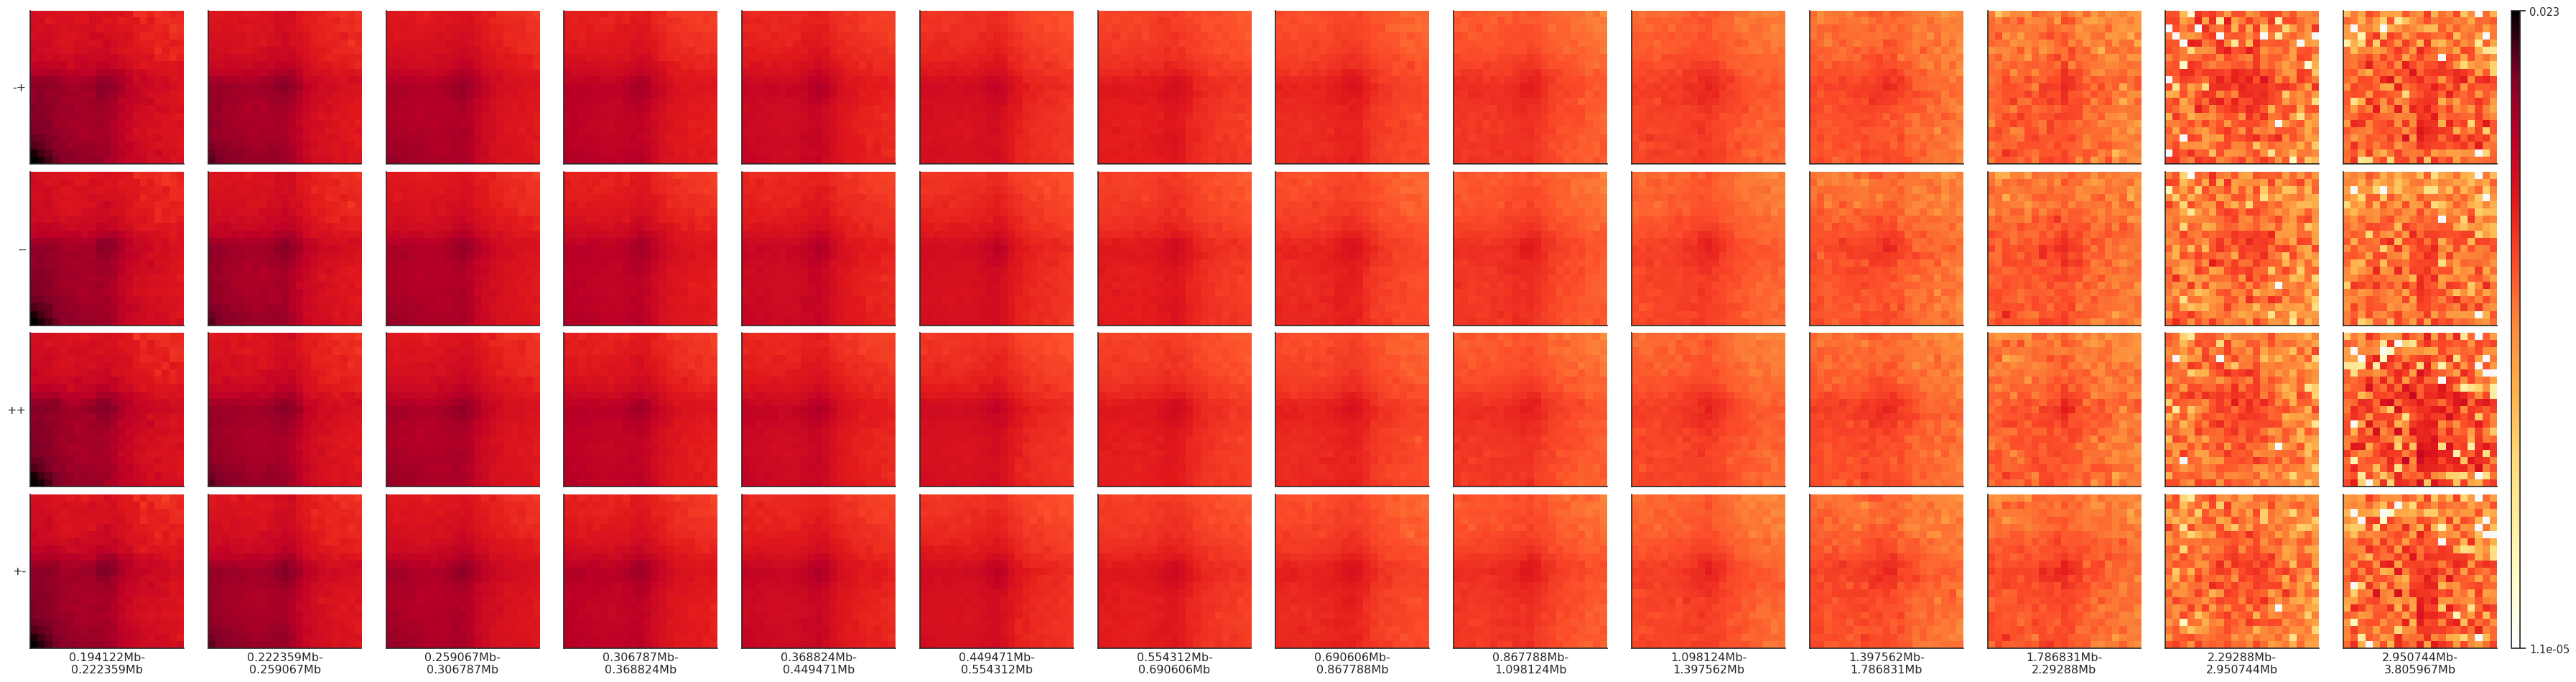

1.7938878814254207e-05


INFO:coolpuppy:('chr14', 'chr14'): 3613
INFO:coolpuppy:('chr18', 'chr18'): 3609
INFO:coolpuppy:('chr19', 'chr19'): 5183
INFO:coolpuppy:('chr13', 'chr13'): 5411
INFO:coolpuppy:('chr10', 'chr10'): 7617
INFO:coolpuppy:('chr12', 'chr12'): 6808
INFO:coolpuppy:('chr17', 'chr17'): 5710
INFO:coolpuppy:('chr3', 'chr3'): 4870
INFO:coolpuppy:('chr16', 'chr16'): 5932
INFO:coolpuppy:('chr15', 'chr15'): 7404
INFO:coolpuppy:('chr6', 'chr6'): 7472
INFO:coolpuppy:('chr4', 'chr4'): 7941
INFO:coolpuppy:('chr1', 'chr1'): 9281
INFO:coolpuppy:('chr8', 'chr8'): 7803
INFO:coolpuppy:('chr11', 'chr11'): 14466
INFO:coolpuppy:('chr5', 'chr5'): 13060
INFO:coolpuppy:('chr9', 'chr9'): 8378
INFO:coolpuppy:('chr2', 'chr2'): 13714
INFO:coolpuppy:('chr7', 'chr7'): 10480
INFO:coolpuppy:Total number of piled up windows: 148752


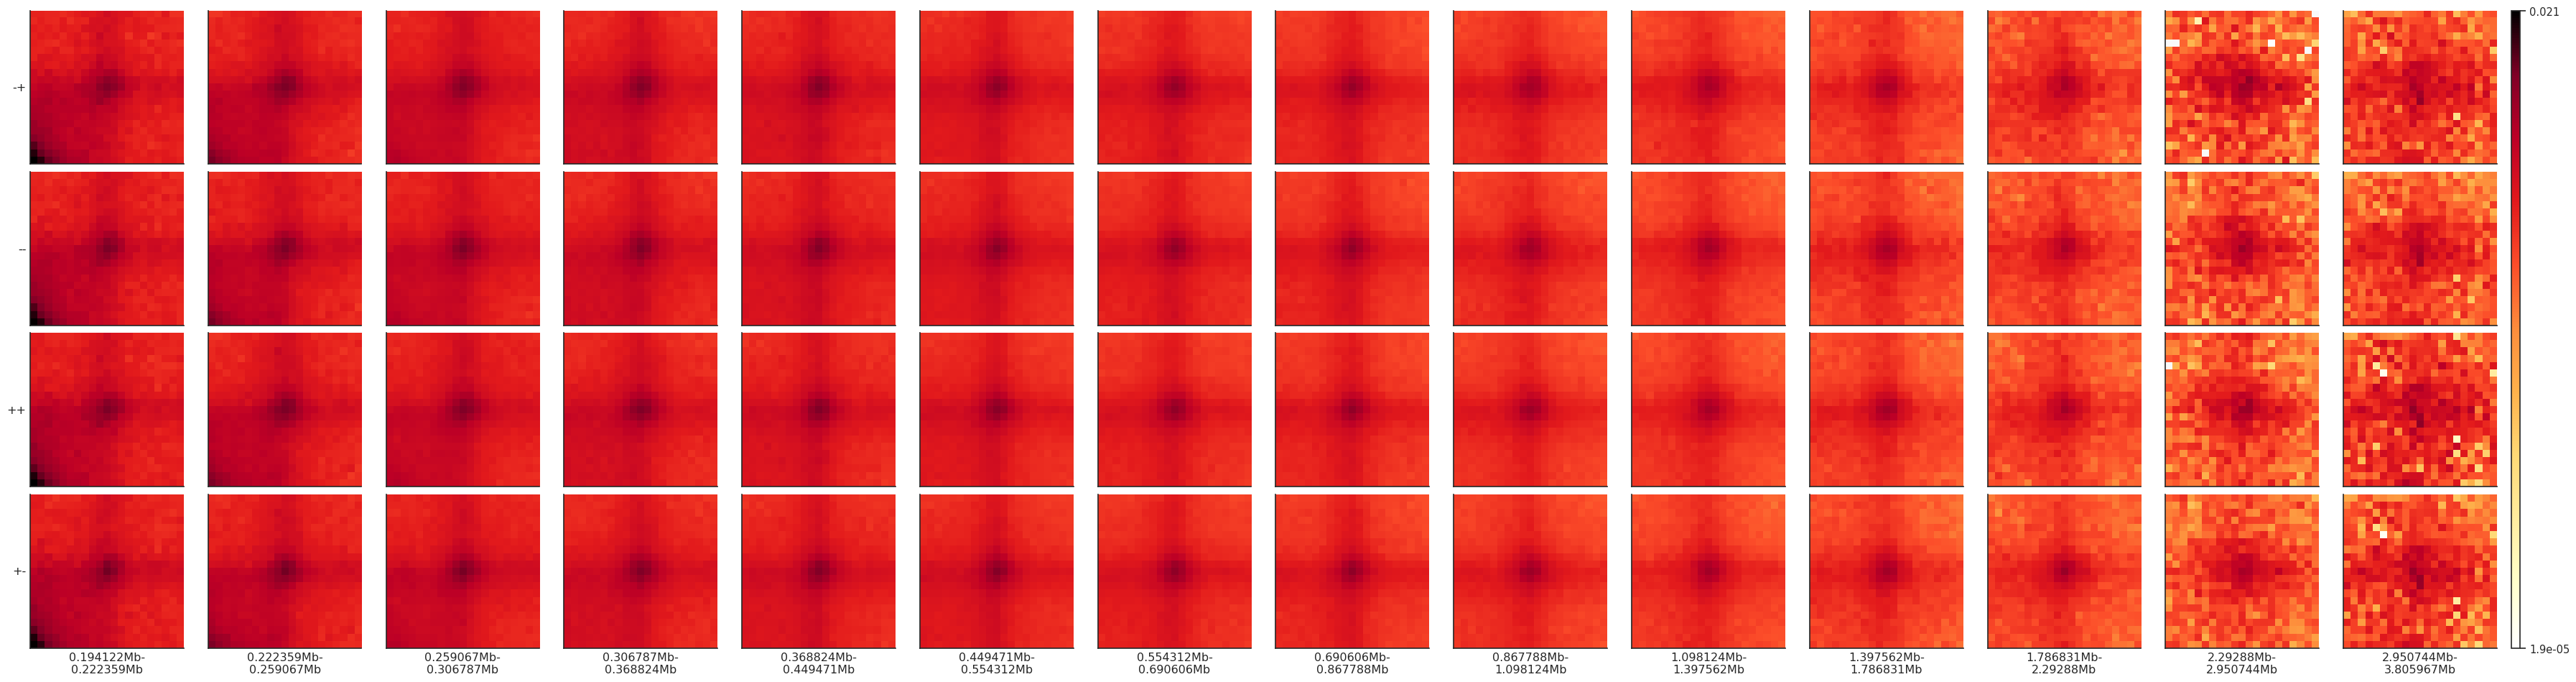

In [24]:
dot_dict = ['cooler_WAPL_0h_pt_0.1', 'cooler_WAPL_0h_pt_0.05', 'cooler_WAPL_6h_pt_0.1']
beginning = 100_000
mindist = 90_000
band_edges = np.append([ beginning, 110_000], (100_000 + 15_000 * 1.3 ** np.arange(1,34)))
band_edge_list=list(band_edges[:])

for name in dot_dict:
    dots = pd.read_table(dot_dir+name+'_all_d10m.tsv')
    dots.rename(columns={'BIN1_CHR':'chrom1',
                     'BIN1_START':'start1','BIN1_END':'end1',
                     'BIN2_CHROMOSOME':'chrom2','BIN2_START':'start2','BIN2_END':'end2',
                    'DETECTION_SCALE':'strength'},inplace=True)
    dots_dist = np.abs((dots['start1']-dots['start2']).values)
    flank_bp = 100_000
    dots_filtered = dots.iloc[ dots_dist > flank_bp*2].reset_index(drop=True)
    dots_filtered_revised = dots_motifs_overlap(dots_filtered, motif)
    sites = dots_filtered_revised.copy()
    
    sample_dict_liu ={
        'Wapl-0h':'GSM5512837_HiC.01_WAPL_0h.mcool',
        'Wapl-6h':'GSM5512838_HiC.02_WAPL_6h.mcool'
    }
    print(band_edge_list)
    mindist = 100_000
    for sample in sample_dict_liu:
        f=open('data/dots_vs_distance_mustache_%s_Liu_mustache_dots_d10m_%s_pseudo_psd1000.csv'%(sample,name),'w')
        f.write('orientation,dist,n,peak_score\n')
        mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
        liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
        clr =  liu_cooler
        view_df=view_df_liu
        cvd = cooltools.expected_cis(
        clr=clr,
        view_df=view_df,
        smooth=True,
        aggregate_smoothed=True,
        nproc=4 #if you do not have multiple cores available, set to 1
        )
        start_regions = []
        for region in view_df['chrom']:
            first_index = cvd['balanced.avg'].loc[cvd['region1'] == region].first_valid_index()
            first_value = cvd['balanced.avg'].loc[first_index]
            start_regions.append(first_value)
        pseudocount = np.mean(start_regions)/1000
        print(pseudocount) 
        pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bedpe', 
                         view_df=view_df_liu.reset_index(drop=True),
                         mindist=1_000,by_distance=np.array(band_edges) ,by_strand=True,flank=100_000, min_diag=2,
                         maxdist=10_000_000,
                         nproc=16
                        )
        for i in range(len(pup['data'])):
            pseudocount = np.mean(np.isfinite(pup['data'][i]))/1000
            score=peak_score(pup['data'][i],3,4,pseudocount)
            if pup['separation'][i]=='all':
                continue
            
            dist=np.mean(pup['distance_band'][i])
            orientation=pup['orientation'][i]
            n = pup['n'][i]
            f.write('%s,%s,%s,%s\n'%(orientation,dist,n,score))

        fg = plotpup.plot(pup,  rows='orientation',
                        cols='separation',
                      row_order=['-+', '--', '++', '+-'],
                        score=False, 
                      cmap='fall', 
                      scale='log', sym=False,
                      height=3)
        
        plt.show()
        f.close()
    

### plotting dot score vs distance 

Hi-c, WT, Bonev 2017 mean score: 1.067821699257671
Weighted average mean for Hi-c, WT, Bonev 2017: 1.004987543957447
Weighted average mean for Hi-c, WT, Bonev 2017 (convergent): 1.0288232079194828
Micro-c, WT, Hsieh 2020, 1.3B reads mean score: 1.0607318634669318
Weighted average mean for Micro-c, WT, Hsieh 2020, 1.3B reads: 0.9929575922057746
Weighted average mean for Micro-c, WT, Hsieh 2020, 1.3B reads (convergent): 1.0160353499379122
Micro-c, WT, Hsieh 2020, 2.6B reads mean score: 1.0649131700589267
Weighted average mean for Micro-c, WT, Hsieh 2020, 2.6B reads: 0.994317012743209
Weighted average mean for Micro-c, WT, Hsieh 2020, 2.6B reads (convergent): 1.0186636517504544
Hi-c, Wapl 6h, Liu 2021 mean score: 1.0843017702501738
Weighted average mean for Hi-c, Wapl 6h, Liu 2021: 1.0293831930510535
Weighted average mean for Hi-c, Wapl 6h, Liu 2021 (convergent): 1.1147278535526208
Hi-c, Wapl 0h, Liu 2021 mean score: 1.0677331424857033
Weighted average mean for Hi-c, Wapl 0h, Liu 2021: 0.

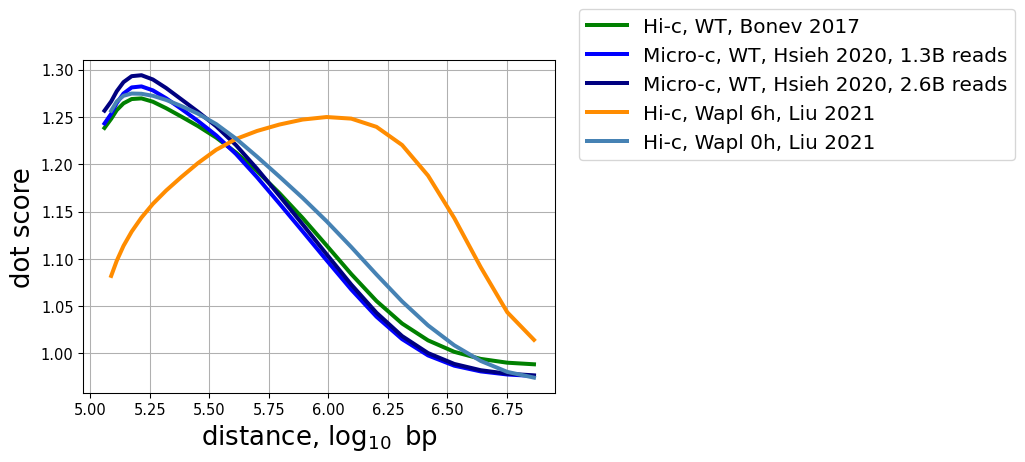

In [16]:
prefix_dir = "../output/scores/experiments/experimental_peak_score/"

datasets = [
    ("dots_vs_distance_peaks_motifs_WT_Bonev_bin_s_Justice_pseudo_ps_1000.csv",
     "Hi-c, WT, Bonev 2017", "green", 1),
    ("dots_vs_distance_peaks_motifs_WT_hsieh_bin_s_Justice_pseudo_ps0.csv",
     "Micro-c, WT, Hsieh 2020, 1.3B reads", "blue", 1),
    ("dots_vs_distance_peaks_motifs_WT_hsieh_r_bin_s_Justice_pseudo_ps0.csv",
     "Micro-c, WT, Hsieh 2020, 2.6B reads", "navy", 1),
    ("dots_vs_distance_peaks_motifs_Wapl-6h_Liu_bin_s_Justice_pseudo_ps_1000.csv",
     "Hi-c, Wapl 6h, Liu 2021", "darkorange", 2),
    ("dots_vs_distance_peaks_motifs_Wapl-0h_Liu_bin_s_Justice_pseudo_ps_1000.csv",
     "Hi-c, Wapl 0h, Liu 2021", "steelblue", 2),
]

def plot_convergent_scores(ax, file_name, label, color, pixel_start=1):
    """Reads data, filters by distance, processes scores, and plots convergent scores."""
    file_path = os.path.join(prefix_dir, file_name)  # Use os.path.join for cross-platform compatibility
    data = pd.read_csv(file_path)
    data = data[data['dist'] <= 7_500_000]
    
    dist_conv = data[data['orientation'] == '+-']['dist']
    score_conv = data[data['orientation'] == '+-']['peak_score']
    score_ave = data.groupby('dist')['peak_score'].mean()
    
    ax.plot(np.log10(dist_conv)[pixel_start:], smooth(score_conv)[pixel_start:], 
            linewidth=3, color=color, label=label)

    mean_score = np.mean(list(score_ave)[1:])
    print(f"{label} mean score: {mean_score}")

    # Weighted mean calculations
    n_tot = data['n'].sum()
    data['score_mult_n'] = data['peak_score'] * data['n']
    data_mean_weight = data['score_mult_n'].sum() / n_tot

    data_conv_wes = data[data['orientation'] == '+-']
    n_conv_tot = data_conv_wes['n'].sum()
    data_mean_weight_conv = data_conv_wes['score_mult_n'].sum() / n_conv_tot

    print(f"Weighted average mean for {label}: {data_mean_weight}")
    print(f"Weighted average mean for {label} (convergent): {data_mean_weight_conv}")

fig, ax = plt.subplots(figsize=(6.35, 4.5))
for file_name, label, color, pixel_start in datasets:
    plot_convergent_scores(ax, file_name, label, color, pixel_start)

# --- Final Plot Formatting ---
ax.grid(True)
ax.set_xlabel(r'distance, $\log_{10}\ \mathrm{bp}$', fontsize=19.5)
ax.set_ylabel('dot score', fontsize=19.5)
ax.tick_params(labelsize=11)
ax.legend(loc=(1.05, 0.7), fontsize=15)
plt.savefig('../output/figures/Hic_microc_dotscore_comparison.pdf', bbox_inches='tight')
plt.show()


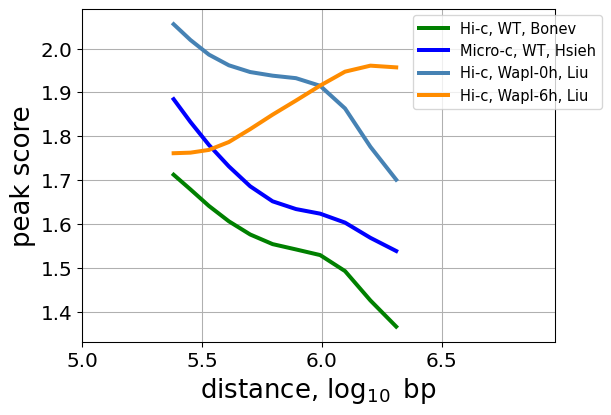

In [17]:
# --- Define Data Paths ---
dot_dict = ['cooler_WAPL_0h_pt_0.1']
bonev_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/'
prefix_dir = "../output/scores/experiments/experimental_peak_score/"

# --- Sample Dictionaries ---
sample_dict = {
    'Wt-Hic': bonev_dir + 'HiC_ES.mm10.mapq_30.1000.mcool::resolutions/10000',
    'Wt-Microc': 'GSE130275_mESC_WT_combined_1.3B.mcool.10000.cool'
}
sample_dict_liu = {
    'Wapl-0h': 'GSM5512837_HiC.01_WAPL_0h.mcool',
    'Wapl-6h': 'GSM5512838_HiC.02_WAPL_6h.mcool'
}

# --- Function to Load & Process Data ---
def load_and_process_data(filepath):
    """Load CSV, filter distances, and return convergent peak scores."""
    data = pd.read_csv(filepath)
    data = data[data['dist'] <= 7500000]
    return data[data['orientation'] == '+-']['dist'], data[data['orientation'] == '+-']['peak_score']

# --- Function to Plot Data ---
def plot_data(ax, dist, score, color, label):
    """Plot log-transformed distance vs smoothed peak score."""
    ax.plot(np.log10(dist)[1:], smooth(score)[1:], linewidth=3, color=color, label=label)

# --- Main Loop for Plotting ---
for name in dot_dict:
    fig, ax = plt.subplots(figsize=(6.35, 4.5))

    # Process and plot Bonev/Hsieh data
    for sample, filepath in sample_dict.items():
        color, label = ('green', 'Hi-c, WT, Bonev') if sample == 'Wt-Hic' else ('blue', 'Micro-c, WT, Hsieh')
        dist, score = load_and_process_data(f"{prefix_dir}dots_vs_distance_mustache_{sample}_mustache_d10m_{name}_pseudo_psd1000.csv")
        plot_data(ax, dist, score, color, label)

    # Process and plot Liu data
    for sample, filepath in sample_dict_liu.items():
        color, label = ('darkorange', 'Hi-c, Wapl-6h, Liu') if sample == 'Wapl-6h' else ('steelblue', 'Hi-c, Wapl-0h, Liu')
        dist, score = load_and_process_data(f"{prefix_dir}dots_vs_distance_mustache_{sample}_Liu_mustache_dots_d10m_{name}_pseudo_psd1000.csv")
        plot_data(ax, dist, score, color, label)

    # Formatting
    ax.set_xlim(5, 6.97)
    ax.set_xlabel(r'distance, $\log_{10}$ bp', fontsize=19.5)
    ax.set_ylabel('peak score', fontsize=19.5)
    ax.tick_params(labelsize=15)
    ax.legend(loc=(0.7, 0.7), fontsize=11)
    ax.grid(True)

    # Save and Show
    plt.savefig('../output/figures/Hic_microc_comparison_mustache.pdf', bbox_inches='tight')
    plt.show()


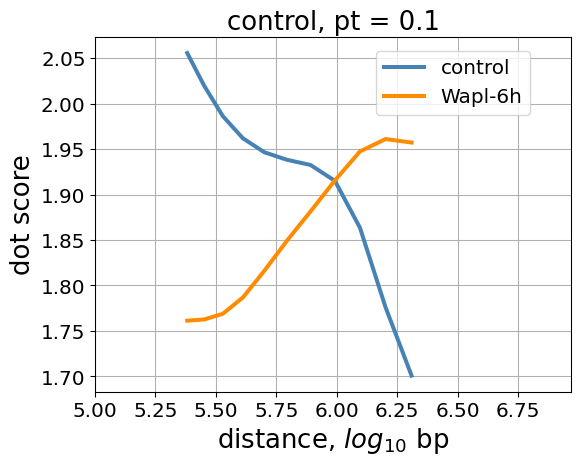

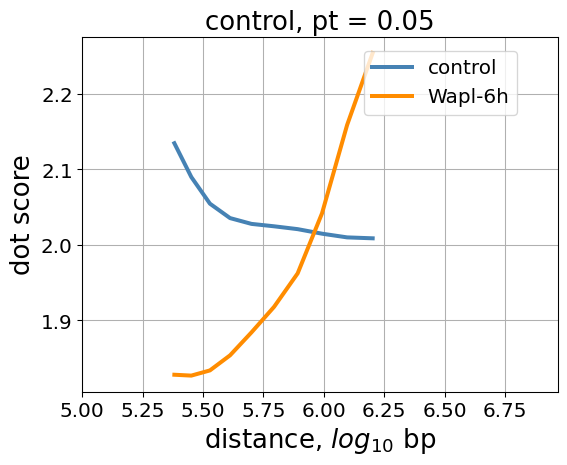

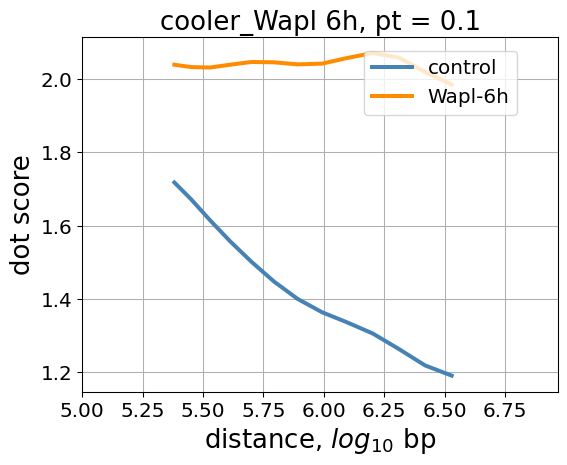

In [18]:
dot_dict = ['cooler_WAPL_0h_pt_0.1','cooler_WAPL_0h_pt_0.05','cooler_WAPL_6h_pt_0.1']
for name in dot_dict:
    for sample in sample_dict_liu:
        if sample=='Wapl-6h':
            color='darkorange'
            label = 'Wapl-6h'
        else: 
            color='steelblue'
            label = 'control'
        data = pd.read_csv(prefix_dir+'dots_vs_distance_mustache_%s_Liu_mustache_dots_d10m_%s_pseudo_psd1000.csv'%(sample,name))
        data = data[data['dist']<=7500000]
        dist_conv=data[data['orientation']=='+-']['dist']
        score_conv=data[data['orientation']=='+-']['peak_score']
        dist_dive=data[data['orientation']=='-+']['dist']
        score_dive=data[data['orientation']=='-+']['peak_score']
        dist_tandemp=data[data['orientation']=='++']['dist']
        score_tandemp=data[data['orientation']=='++']['peak_score']
        dist_tandemn=data[data['orientation']=='--']['dist']
        score_tandemn=data[data['orientation']=='--']['peak_score']
        score_ave=data.groupby('dist')['peak_score'].mean()
        pixel_start =1
        plt.plot(np.log10(dist_conv)[pixel_start:],smooth(score_conv)[pixel_start:],linewidth = 3, color=color,label=label)
    plt.grid(True)
    plt.xlim(5,6.97)
    #plt.ylim(0.95,1.91)
    if name=='cooler_WAPL_0h_pt_0.1':
            namea='control, pt = 0.1'
    elif name=='cooler_WAPL_0h_pt_0.05':
        namea = 'control, pt = 0.05'
    else:
        namea = 'cooler_Wapl 6h, pt = 0.1'
    plt.title(namea, fontsize=19.5)
    plt.ylabel('dot score',fontsize = 19.5)
    plt.xlabel(r'distance, $log_{10}$ bp', fontsize = 19.5)
    plt.legend(loc=(0.591,0.781), fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.savefig('figures/peaks_new_sup/observed_for_ctcf&motifs_from_papers_bin_sconv_dots_%s.pdf'%name, bbox_inches = 'tight')
    plt.show()

### taking the mustache peaks

5
WAPL_0h_pt_0.1 Wapl-0h


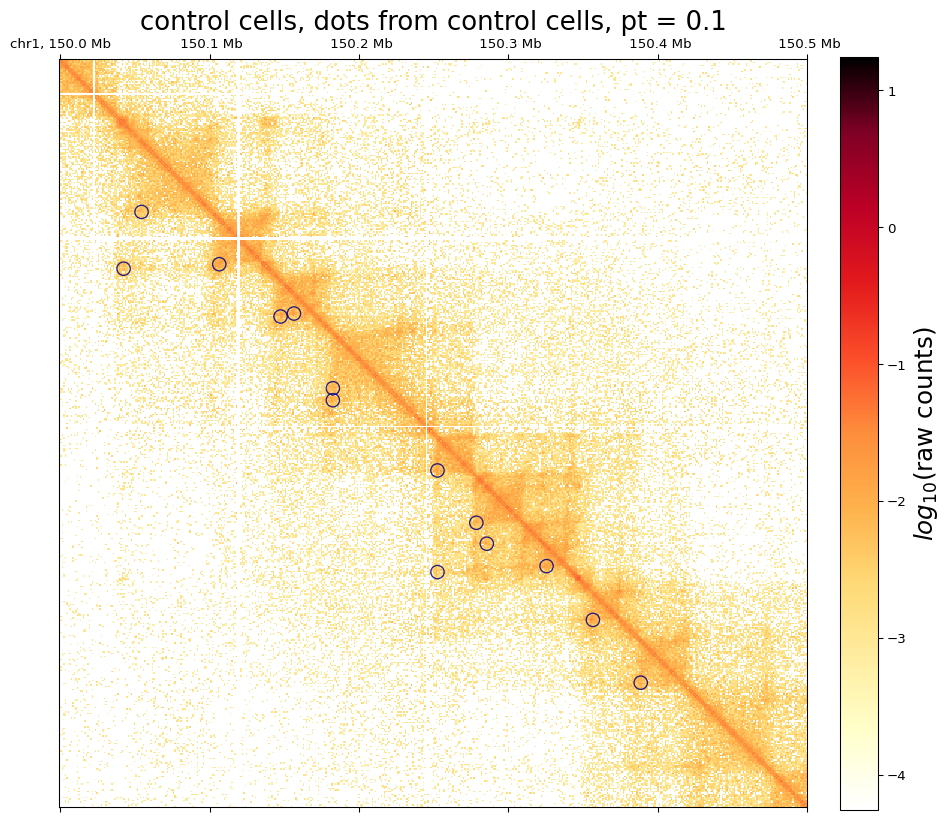

5
WAPL_0h_pt_0.1 Wapl-6h


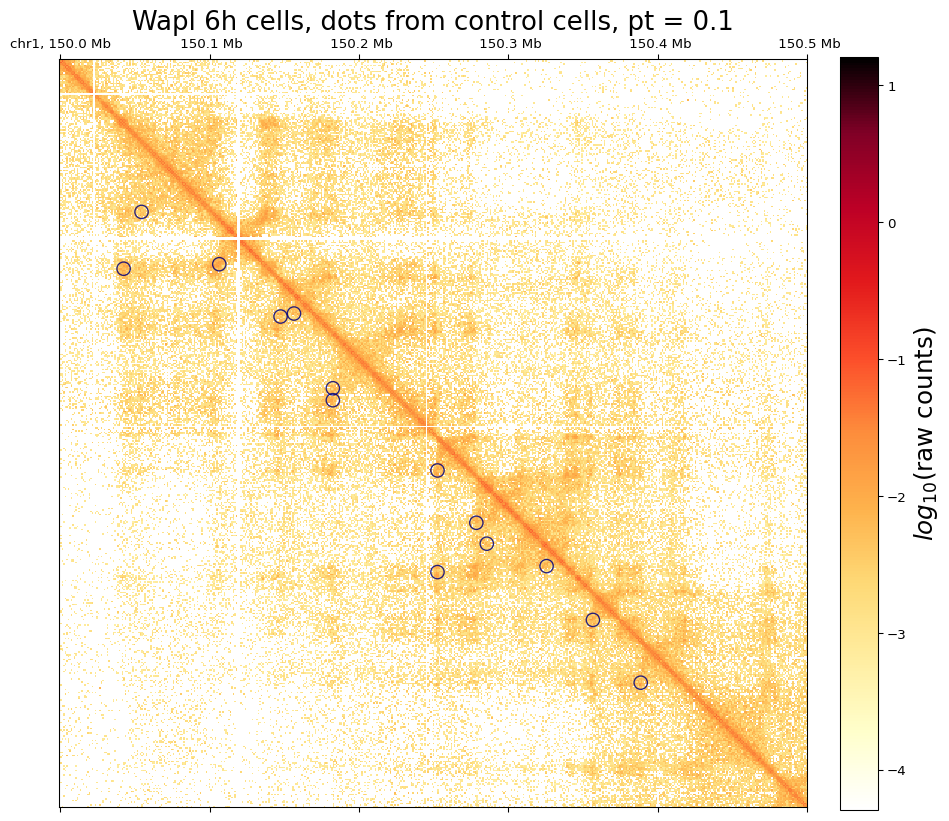

5
WAPL_0h_pt_0.05 Wapl-0h


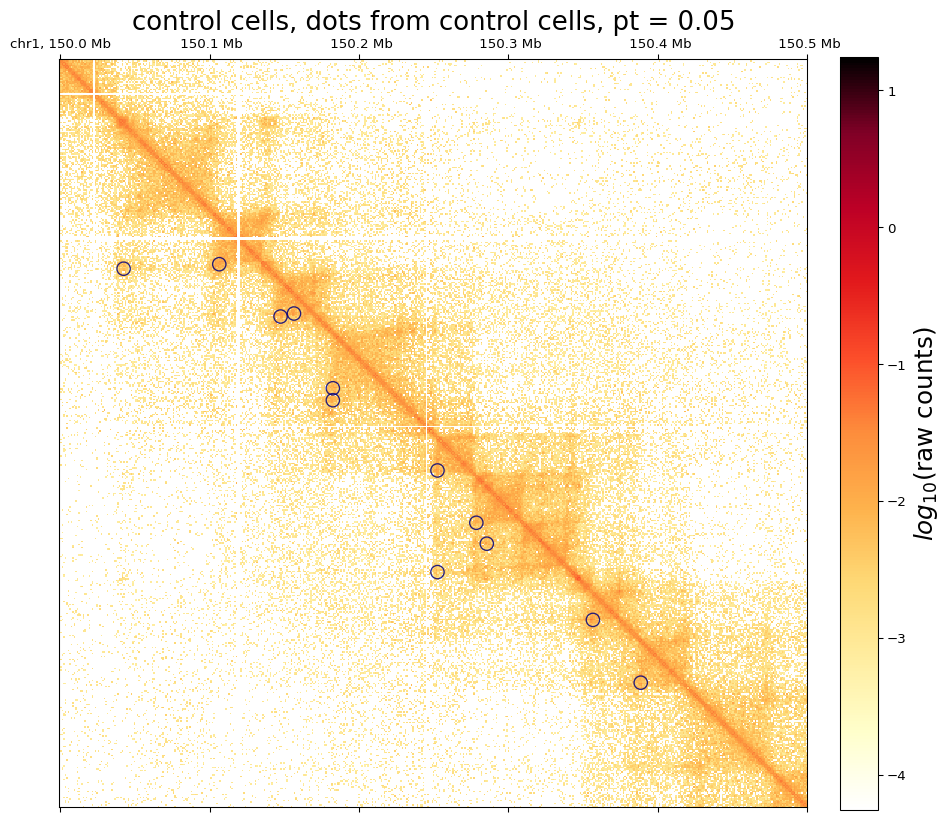

5
WAPL_0h_pt_0.05 Wapl-6h


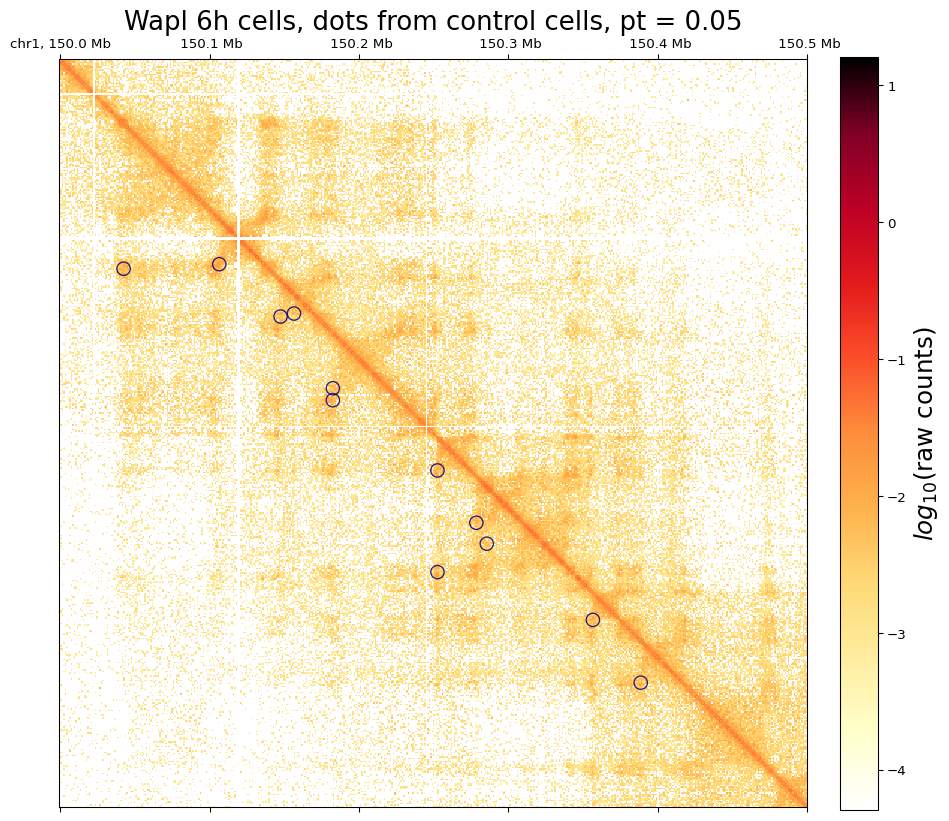

5
WAPL_6h_pt_0.1 Wapl-0h


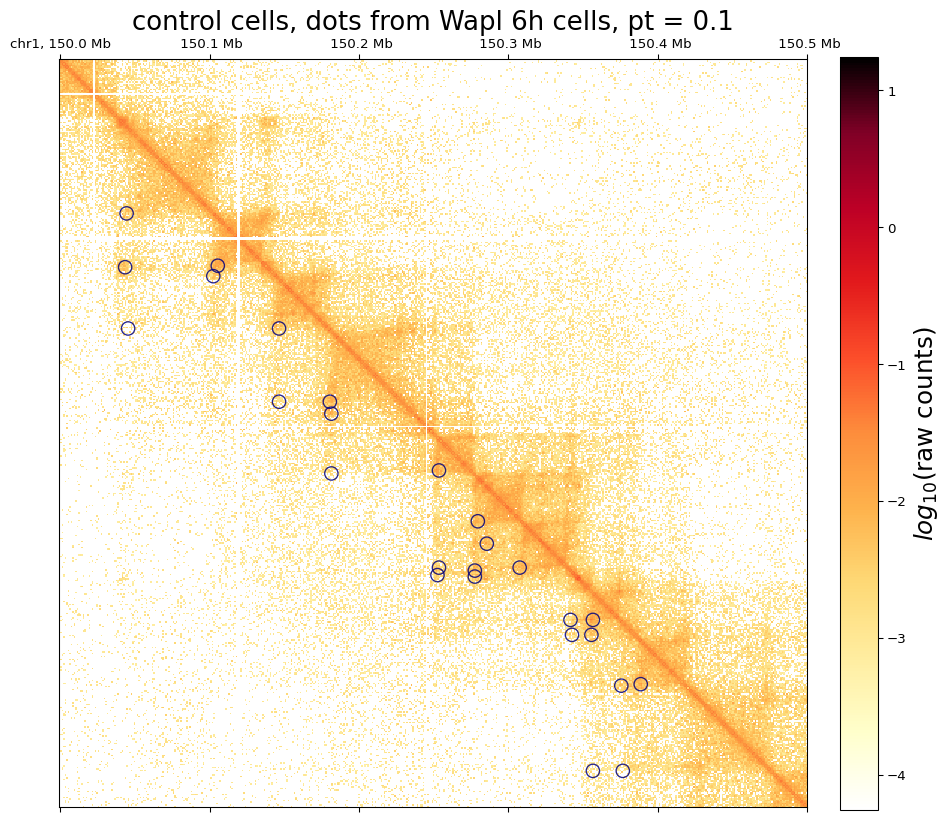

5
WAPL_6h_pt_0.1 Wapl-6h


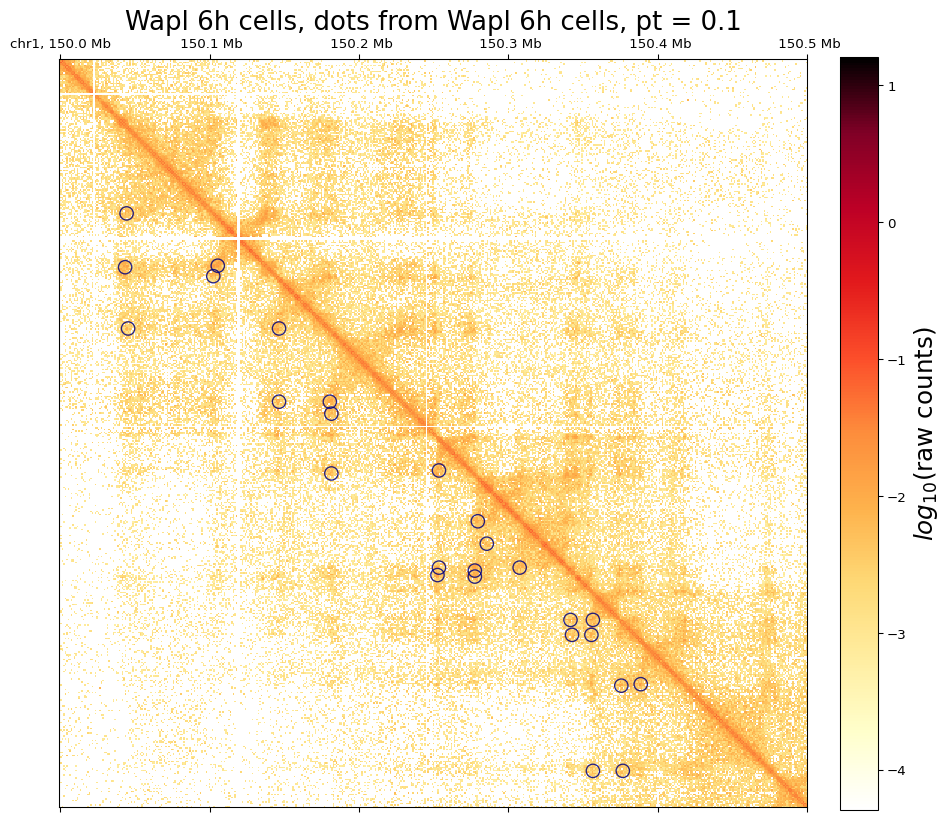

In [20]:
dot_dict = ['WAPL_0h_pt_0.1','WAPL_0h_pt_0.05','WAPL_6h_pt_0.1']

for name in dot_dict:
    dots = pd.read_table(dot_dir+'cooler_'+name+'_all_d10m.tsv')
    dots.rename(columns={'BIN1_CHR':'chrom1',
                     'BIN1_START':'start1','BIN1_END':'end1',
                     'BIN2_CHROMOSOME':'chrom2','BIN2_START':'start2','BIN2_END':'end2',
                    'DETECTION_SCALE':'strength'},inplace=True)
    
    sample_dict_liu ={
        'Wapl-0h':'GSM5512837_HiC.01_WAPL_0h.mcool',
        'Wapl-6h':'GSM5512838_HiC.02_WAPL_6h.mcool'
    }
    mindist = 100_000
    for sample in sample_dict_liu:
        mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
        liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
        clr =  liu_cooler
        view_df=view_df_liu


        plt.figure(figsize=(11,11))
        cname =  bonev_file
        cname = mcool_path_liu
        region = 'chr1:150000000-155000000'
        region_start = bioframe.parse_region_string(region)[1]
        region_end = bioframe.parse_region_string(region)[2]
        mat = (cooler.Cooler(cname+'::resolutions/'+str(res)).matrix(balance=True).fetch(region))
        im = plt.matshow(np.log10(mat), 
                         vmax = np.log10(np.nanmedian(np.diag(mat,2)))+3, 
                         vmin= np.log10(np.nanmedian(np.diag(mat,2)))-2.5, 
                         fignum=False ,cmap='fall' ); 
        cbar = plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(raw counts)')
        cbar.set_label(r'$log_{10}$(raw counts)', fontsize=18.5) 
        ## plotting the dots ##
        region_dots = bioframe.select(dots, region, cols=['chrom1','start1','end1'])
        for i in range(len(region_dots)):
            s1,s2,e1,e2 =( ( region_dots[['start1','end1','start2','end2']].iloc[i].values.astype(int)
                            -region_start) //res ) 
            x,e = .5*(s1+s2), .5*(e1+e2)
            if x < 0 or e > len(mat): continue
            plt.scatter(  x,e,marker='o',color= 'navy',s=100,facecolor='none',alpha=0.85)
        
        plt.grid(False)
        plt.yticks([])
        region_start = bioframe.parse_region_string(region)[1]
        region_end = bioframe.parse_region_string(region)[2]
        xtr = np.arange(0, (region_end-region_start)//res+100, 100)
        print((region_end-region_start)//res//100)
        plt.xticks(list(xtr))
        #plt.yticks([0,100,200,300,400,500])
        xlabels = ['chr1, 150.0 Mb', ' 150.1 Mb', ' 150.2 Mb', ' 150.3 Mb', ' 150.4 Mb', ' 150.5 Mb']
        #xlabels = [f'chr1, {region_start//(100*res)+0.1 * (i)} Mb' for i in range(6)]
        plt.gca().set_xticklabels(xlabels)
        if sample=='Wapl-0h':
            samplea='control'
        else:
            samplea='Wapl 6h'
        if name=='WAPL_0h_pt_0.1':
            namea='control cells, pt = 0.1'
        elif name=='WAPL_0h_pt_0.05':
            namea = 'control cells, pt = 0.05'
        else:
            namea = 'Wapl 6h cells, pt = 0.1'
        print(name, sample)
        plt.title(samplea + ' cells'+','+ ' dots from ' + namea , fontsize= 19.5)
        #plt.savefig('figures/peaks_new_sup/sample_%s_%s.pdf'%(name, sample))
        plt.show()

    